In [1]:
from tools import *
import json
#from webapp import *
import pyodbc
#IMPORT DATABASE FROM SQL SERVER AND FIT DATA JUST OFF OF THE DATABASE

In [2]:
server = 'wdtdevsql02'
database = 'WDT_PROD'
username= 'application'
password= '!v80VD8gX!vK'
pyodbc_cnntr = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password

In [3]:
'''server: wdtdevsql02
database: WDT_PROD
login: application
password: !v80VD8gX!vK'''

'server: wdtdevsql02\ndatabase: WDT_PROD\nlogin: application\npassword: !v80VD8gX!vK'

In [4]:
to_return = {}  
cnxn = pyodbc.connect(pyodbc_cnntr)
cursor = cnxn.cursor()    
cursor.execute("SELECT Frequency_Hz, Minus_Z_Imaginary_Ohm, Z_Real_Ohm FROM ACImpedanceData_Raw WHERE Cycle = 1 and ProcessDataID = 737864")
for row in cursor.fetchall():
    to_return.update({row.Frequency_Hz: [row.Z_Real_Ohm, row.Minus_Z_Imaginary_Ohm]})
cnxn.close()

In [36]:
to_return.keys()

dict_keys([1.0000637, 1.1224855, 1.2596743, 1.4122375, 1.5840428, 1.7796121, 1.9970596, 2.2398219, 2.513674, 2.8183618, 3.1603959, 3.5511355, 3.9778507, 4.4693928, 5.0144405, 5.6205029, 6.3105812, 7.0765405, 7.9395342, 8.9183798, 10.003201, 11.224855, 12.600808, 14.118973, 15.857575, 17.796127, 19.955299, 22.385387, 25.104427, 28.170067, 31.629551, 35.465298, 39.80891, 44.671211, 50.144405, 56.241814, 63.160748, 70.838745, 79.415459, 89.115974, 100.03201, 112.18996, 125.84568, 141.31134, 158.42838, 177.78128, 199.55299, 223.92513, 251.04428, 281.89429, 316.31577, 354.65948, 398.08911, 446.8588, 501.44406, 562.33917, 631.00952, 707.50946, 794.23767, 891.42584, 1000.3201, 1121.7948, 1258.7914, 1411.8373, 1585.5067, 1778.2926, 1995.6382, 2237.8513, 2510.8032, 2817.2952, 3161.0105, 3546.5947, 3981.2732, 4466.4282, 5011.6025, 5647.2573, 6332.9521, 7124.3867, 7944.2559, 8979.9863, 10019.531, 11220.699, 12587.886, 14121.09, 15849.605, 17783.199, 19951.164, 22382.803, 25117.182, 28183.59, 3162

In [37]:
import pprint
pp = pprint.PrettyPrinter(width=41, compact=True)
pp.pprint(to_return)
#self, params, circuit, weight_func='modulus', nan_policy='raise', maxfev = 10
#minimize(self.leastsq_errorfunc, params, method='leastsq', args=(self.df[i].w.values, self.df[i].re.values, self.df[i].im.values, circuit, weight_func), nan_policy=nan_policy, maxfev=maxfev)
#to_return

{1.0000637: [25524996.0, 5322199.0],
 1.1224855: [25198394.0, 5468659.0],
 1.2596743: [24708566.0, 5800842.0],
 1.4122375: [24416218.0, 5929125.5],
 1.5840428: [24262230.0, 5756475.5],
 1.7796121: [23679500.0, 6118924.5],
 1.9970596: [23172492.0, 6331669.5],
 2.2398219: [22821876.0, 6360373.5],
 2.513674: [22431738.0, 6654888.5],
 2.8183618: [22018528.0, 6734998.5],
 3.1603959: [21492932.0, 6943168.5],
 3.5511355: [20987878.0, 6915280.5],
 3.9778507: [20426124.0, 7380130.0],
 4.4693928: [19743972.0, 7714598.0],
 5.0144405: [19489748.0, 8027859.5],
 5.6205029: [19501802.0, 7654888.5],
 6.3105812: [17957812.0, 7786491.5],
 7.0765405: [17295566.0, 8261442.0],
 7.9395342: [16700054.0, 8772757.0],
 8.9183798: [16152548.0, 8554055.0],
 10.003201: [15760374.0, 8834763.0],
 11.224855: [14564249.0, 8894460.0],
 12.600808: [13724772.0, 9258300.0],
 14.118973: [12983082.0, 9263558.0],
 15.857575: [11527969.0, 9403910.0],
 17.796127: [11302319.0, 9344952.0],
 19.955299: [10578121.0, 9263836.0],
 2

In [38]:
def leastsq_errorfunc(params, w, re, im, circuit, weight_func = 'modulus'):
        if circuit == 'R-RQ-RQ':
            re_fit = cir_RsRQRQ_fit(params, w).real
            im_fit = -cir_RsRQRQ_fit(params, w).imag
        elif circuit == 'R-RQ-Q':
            re_fit = cir_RsRQQ_fit(params, w).real
            im_fit = -cir_RsRQQ_fit(params, w).imag
        elif circuit == 'R-RQ-RQ2':
            re_fit = cir_RsRQRQ2_fit(params, w).real
            im_fit = -cir_RsRQRQ2_fit(params, w).imag
        elif circuit == 'R-RQ-RQ-Q':
            re_fit = cir_RsRQRQQ_fit(params, w).real
            im_fit = -cir_RsRQRQQ_fit(params, w).imag
        else:
            print('Circuit is not defined in leastsq_errorfunc()')

        error = ([(re-re_fit)**2, (im-im_fit)**2]) #sum of squares
        
        #Different Weighing options, see Lasia
        if weight_func == 'modulus':
            weight = [1/((re_fit**2 + im_fit**2)**(1/2)), 1/((re_fit**2 + im_fit**2)**(1/2))]
        elif weight_func == 'proportional':
            weight = [1/(re_fit**2), 1/(im_fit**2)]
        elif weight_func == 'unity':
            unity_1s = []
            for k in range(len(re)):
                unity_1s.append(1) #makes an array of [1]'s, so that the weighing is == 1 * sum of squres.
            weight = [unity_1s, unity_1s]
        else:
            print('weight not defined in leastsq_errorfunc()')
        
        S = np.array(weight) * error #weighted sum of squares 
        return S

In [39]:
#Formatting the database results into pd series for minimizing module function

freq = pd.Series([np.float64(i) for i in list(to_return.keys())])
re = pd.Series([np.float64(i[0]) for i in list(to_return.values())])
im = pd.Series([np.float(i[1]) for i in list(to_return.values())])
init_guesses = []
param_list = []
#pre_coeffs = []
for i in range(20):
    #initial guesses still rely on the real values
    Rs_guess = min(re)
    R1_guess = max(re)//4
    n1_guess = random.uniform(0, 1)
    q1_guess = random.uniform(0, .001)
    R2_guess = 2*max(re)//4
    n2_guess = random.uniform(0, 1)
    q2_guess = random.uniform(0, .001)
    Q3_guess = random.uniform(0, .001)
    n3_guess = random.uniform(0, 1)
    params = Parameters()
    params.add('Rs', value=Rs_guess, min=Rs_guess*.001, max=Rs_guess*10)
    params.add('R1', value=R1_guess, min=R1_guess*.001, max=R1_guess*10)
    params.add('n1', value=n1_guess, min=0, max=1)
    params.add('Q1', value=q1_guess, min=0, max=.001)
    params.add('R2', value=R2_guess, min=R2_guess*.001, max=R2_guess*10)
    params.add('n2', value=n2_guess, min=.01, max=1)
    params.add('Q2', value=q2_guess, min=0, max=.001)
    params.add('Q', value=Q3_guess, min=0, max=.001)
    params.add('n', value=n3_guess, min=.01, max=1)
    param_list.append(params)
    circuit = 'R-RQ-RQ-Q'
    weight_func = 'modulus'
    nan_policy = 'raise'
    maxfev = 5000
    #MINIMIZE CANNOT TAKE IN LISTS
    #IT MUST BE PD SERIES
    #ALSO IT MUST BE CALLED SERIES.VALUES
    #NOT JUST SERIES
    fitted_data = minimize(leastsq_errorfunc, params, method='leastsq', args=(freq.values, re.values, im.values, circuit, weight_func), nan_policy=nan_policy, maxfev=maxfev)
    #pre_coeffs.append(fitted_data.params.valuesdict())
    print("CHI-SQ ERROR: ", fitted_data.chisqr)
    init_guesses.append(fitted_data.chisqr)
    #print("PARAMS")
    #pp.pprint(fitted_data.params)
optimal_params = param_list[init_guesses.index(min(init_guesses))]
fitted_dict = optimal_params.valuesdict()

CHI-SQ ERROR:  254177885626.75287
CHI-SQ ERROR:  231824889170968.22
CHI-SQ ERROR:  4172181735964961.0
CHI-SQ ERROR:  16462963953.87888
CHI-SQ ERROR:  1660847113.6324604
CHI-SQ ERROR:  16283217407.227306
CHI-SQ ERROR:  233086554572589.2
CHI-SQ ERROR:  1817106550336216.5
CHI-SQ ERROR:  230565737447213.3
CHI-SQ ERROR:  16391514617.573746
CHI-SQ ERROR:  3318200531.7113624
CHI-SQ ERROR:  230609492724515.0
CHI-SQ ERROR:  3325674729.651028
CHI-SQ ERROR:  19888247739.343285
CHI-SQ ERROR:  16303999311.67537
CHI-SQ ERROR:  249673347352.46808
CHI-SQ ERROR:  231339179926693.9
CHI-SQ ERROR:  259151344923.62003
CHI-SQ ERROR:  230827954865010.16
CHI-SQ ERROR:  3363824187.87012


In [40]:
fitted_data=minimize(leastsq_errorfunc, optimal_params, method='leastsq', args=(freq.values, re.values, im.values, circuit, weight_func), nan_policy=nan_policy, maxfev=maxfev)

In [41]:
fitted_dict = optimal_params.valuesdict()
fitted_dict['file'] = 737864
fitted_dict

OrderedDict([('Rs', 729.93665),
             ('R1', 6381249.0),
             ('n1', 0.3231738083078838),
             ('Q1', 0.0007729721415168058),
             ('R2', 12762498.0),
             ('n2', 0.21015868883271094),
             ('Q2', 7.616810473252767e-05),
             ('Q', 0.00036700784905847764),
             ('n', 0.6504153855737983),
             ('file', 737864)])

No handles with labels found to put in legend.


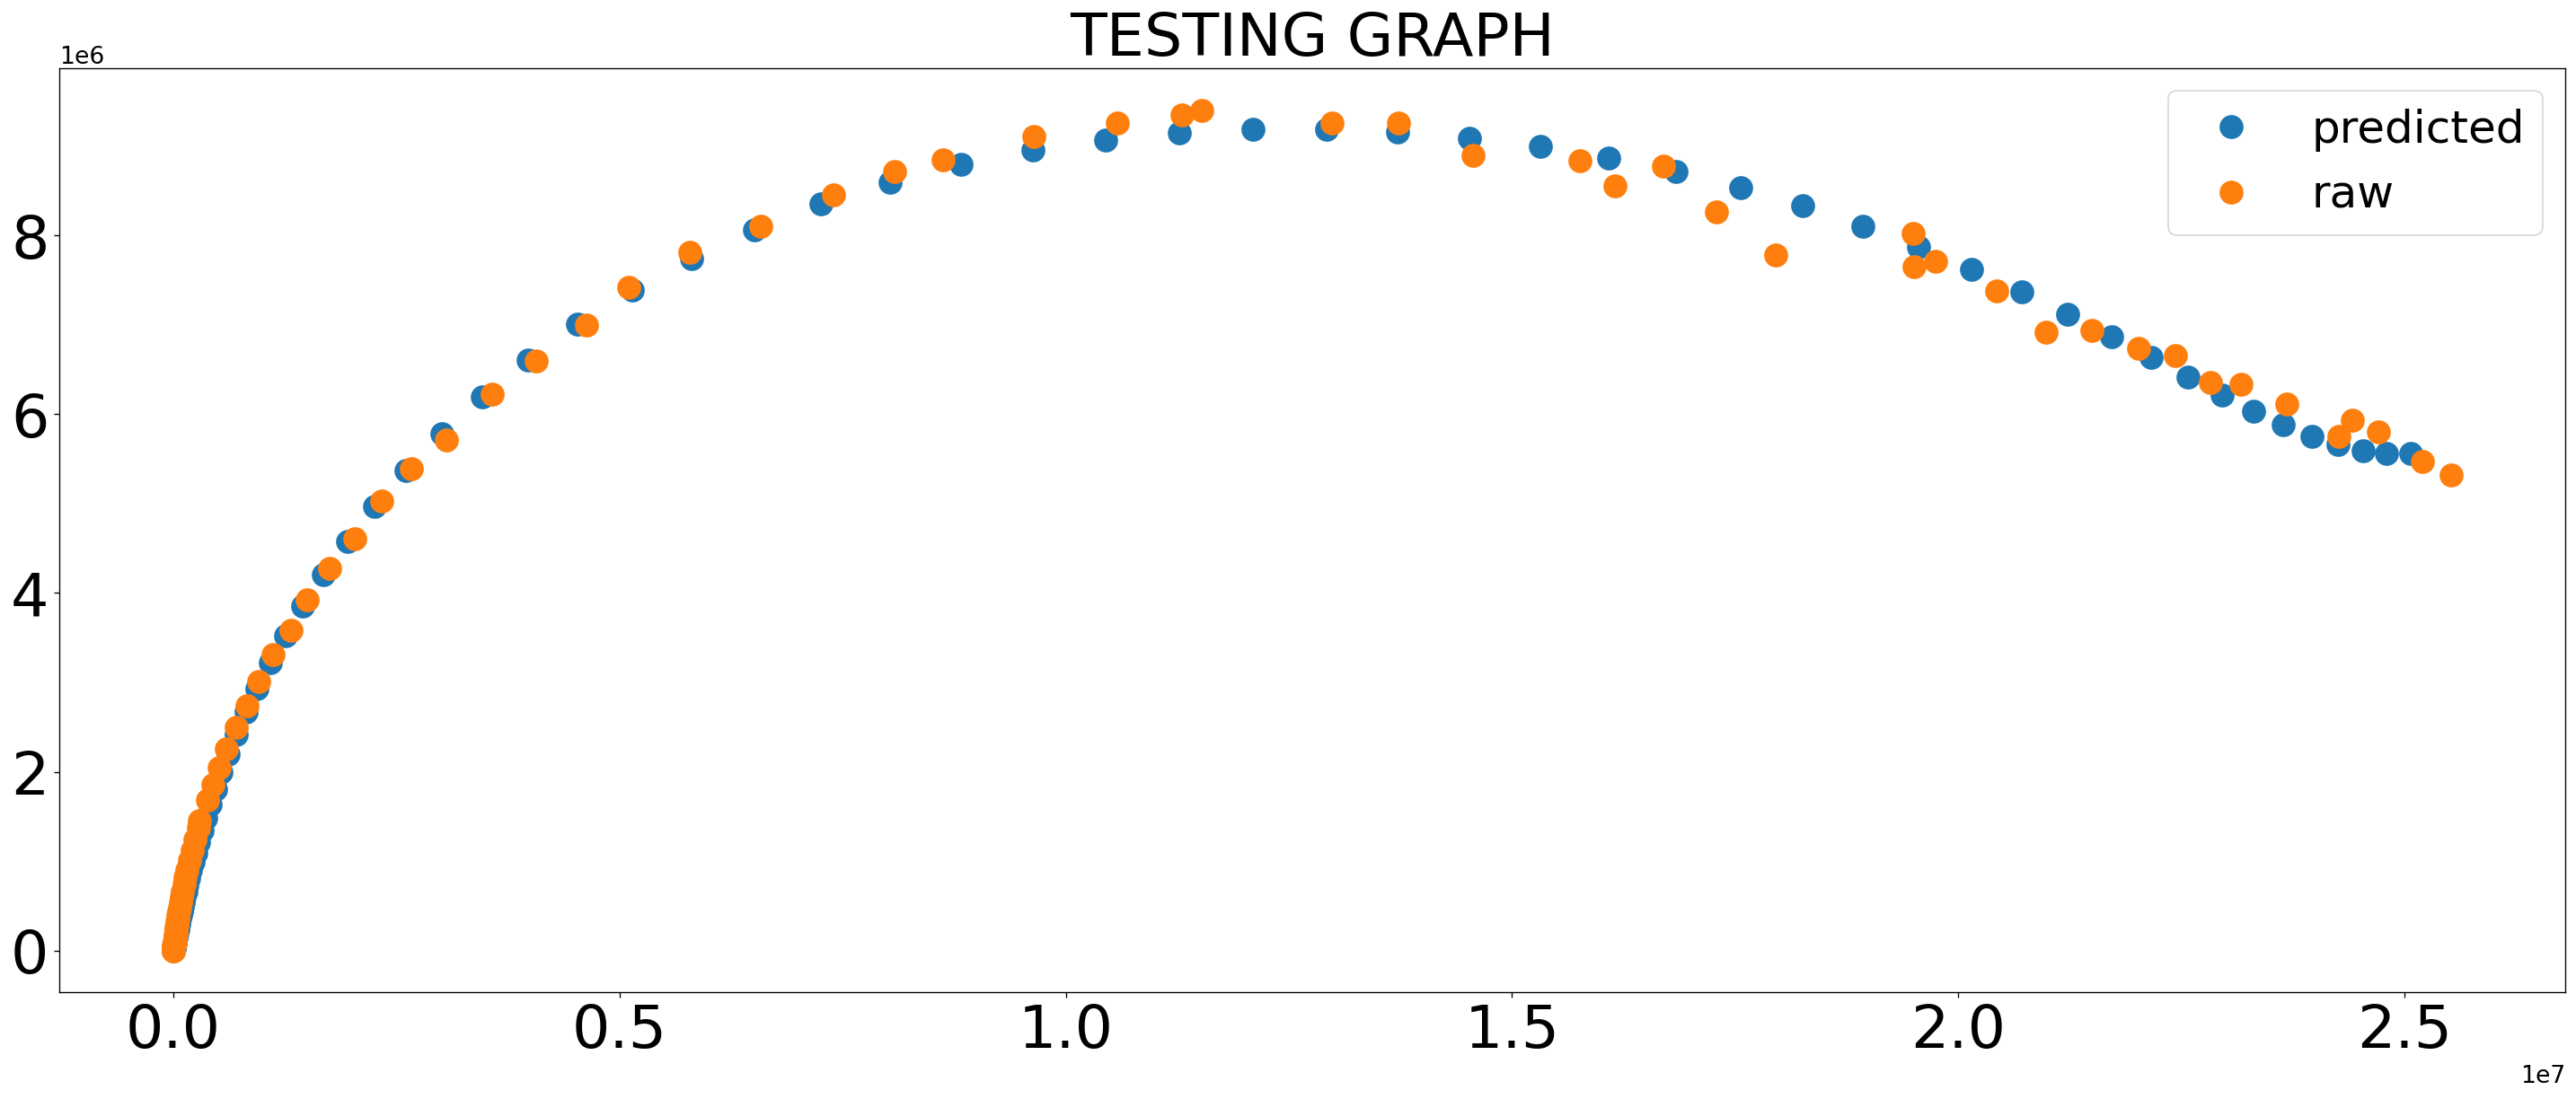

In [42]:
#PLOTTING
#Collecting the fitted data to prepare for plotting te points
fitted_points = cir_RsRQRQQ(w=freq.values, Rs=fitted_data.params.get('Rs').value, Q=fitted_data.params.get('Q').value, n=fitted_data.params.get('n').value, R1=fitted_data.params.get('R1').value, Q1=fitted_data.params.get('Q1').value, n1=fitted_data.params.get('n1').value, fs1='None', R2=fitted_data.params.get('R2').value, Q2=fitted_data.params.get('Q2').value, n2=fitted_data.params.get('n2').value, fs2='None')
fig = plt.figure(dpi=120, figsize = [30, 25], facecolor='w', edgecolor='w')
#fig.subplots_adjust(left=0.1, right=0.95, hspace=0.5, bottom=0.1, top=0.95)
ax = fig.add_subplot(211)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.tick_params(axis='both', which='minor', labelsize=40)
### Figure specifics
ax.set_title("TESTING GRAPH", fontsize = 40)
ax.legend(loc='best', fontsize=30, frameon=False)
#Color initialization
colors = sns.color_palette("colorblind", n_colors=1)
colors_real = sns.color_palette("Blues", n_colors=2)
colors_imag = sns.color_palette("Oranges", n_colors=2)
ax.plot(fitted_points.real, -fitted_points.imag, '.', label = 'predicted', markersize = 30)
ax.plot(re, im, '.', label = 'raw', markersize = 30)
ax.legend(fontsize = 30)
plt.show()

In [57]:
#GOING TO TRY TO COLLECT WITH DATAFILE IDS FROM THE DATABASE
#SQL SEEMS TO NOT BE WORKING RIGHT NOW...
import csv
ids = []
cnxn = pyodbc.connect(pyodbc_cnntr)
cursor = cnxn.cursor()  

#Will try to collect in this manner  
cursor.execute("SELECT DISTINCT ProcessDataID FROM ACImpedanceData_Raw")

row = cursor.fetchall()
with open('test_sql_data.csv', 'w', newline='') as fp:
        a = csv.writer(fp, delimiter=',')
        a.writerows(row)
cnxn.close()

In [60]:
#PULL ALL CURRENT DATA FROM SQL SERVER
import csv
cnxn = pyodbc.connect(pyodbc_cnntr)
cursor = cnxn.cursor()  

#Will try to collect in this manner  
cursor.execute("SELECT ProcessDataID, Frequency_Hz, Minus_Z_Imaginary_Ohm, Z_Real_Ohm FROM ACImpedanceData_Raw WHERE Cycle = 1")

row = cursor.fetchall()
with open('all_current_sql_data.csv', 'w', newline='') as fp:
        a = csv.writer(fp, delimiter=',')
        a.writerows(row)
cnxn.close()

Progress:0.0236127509%
No handles with labels found to put in legend.


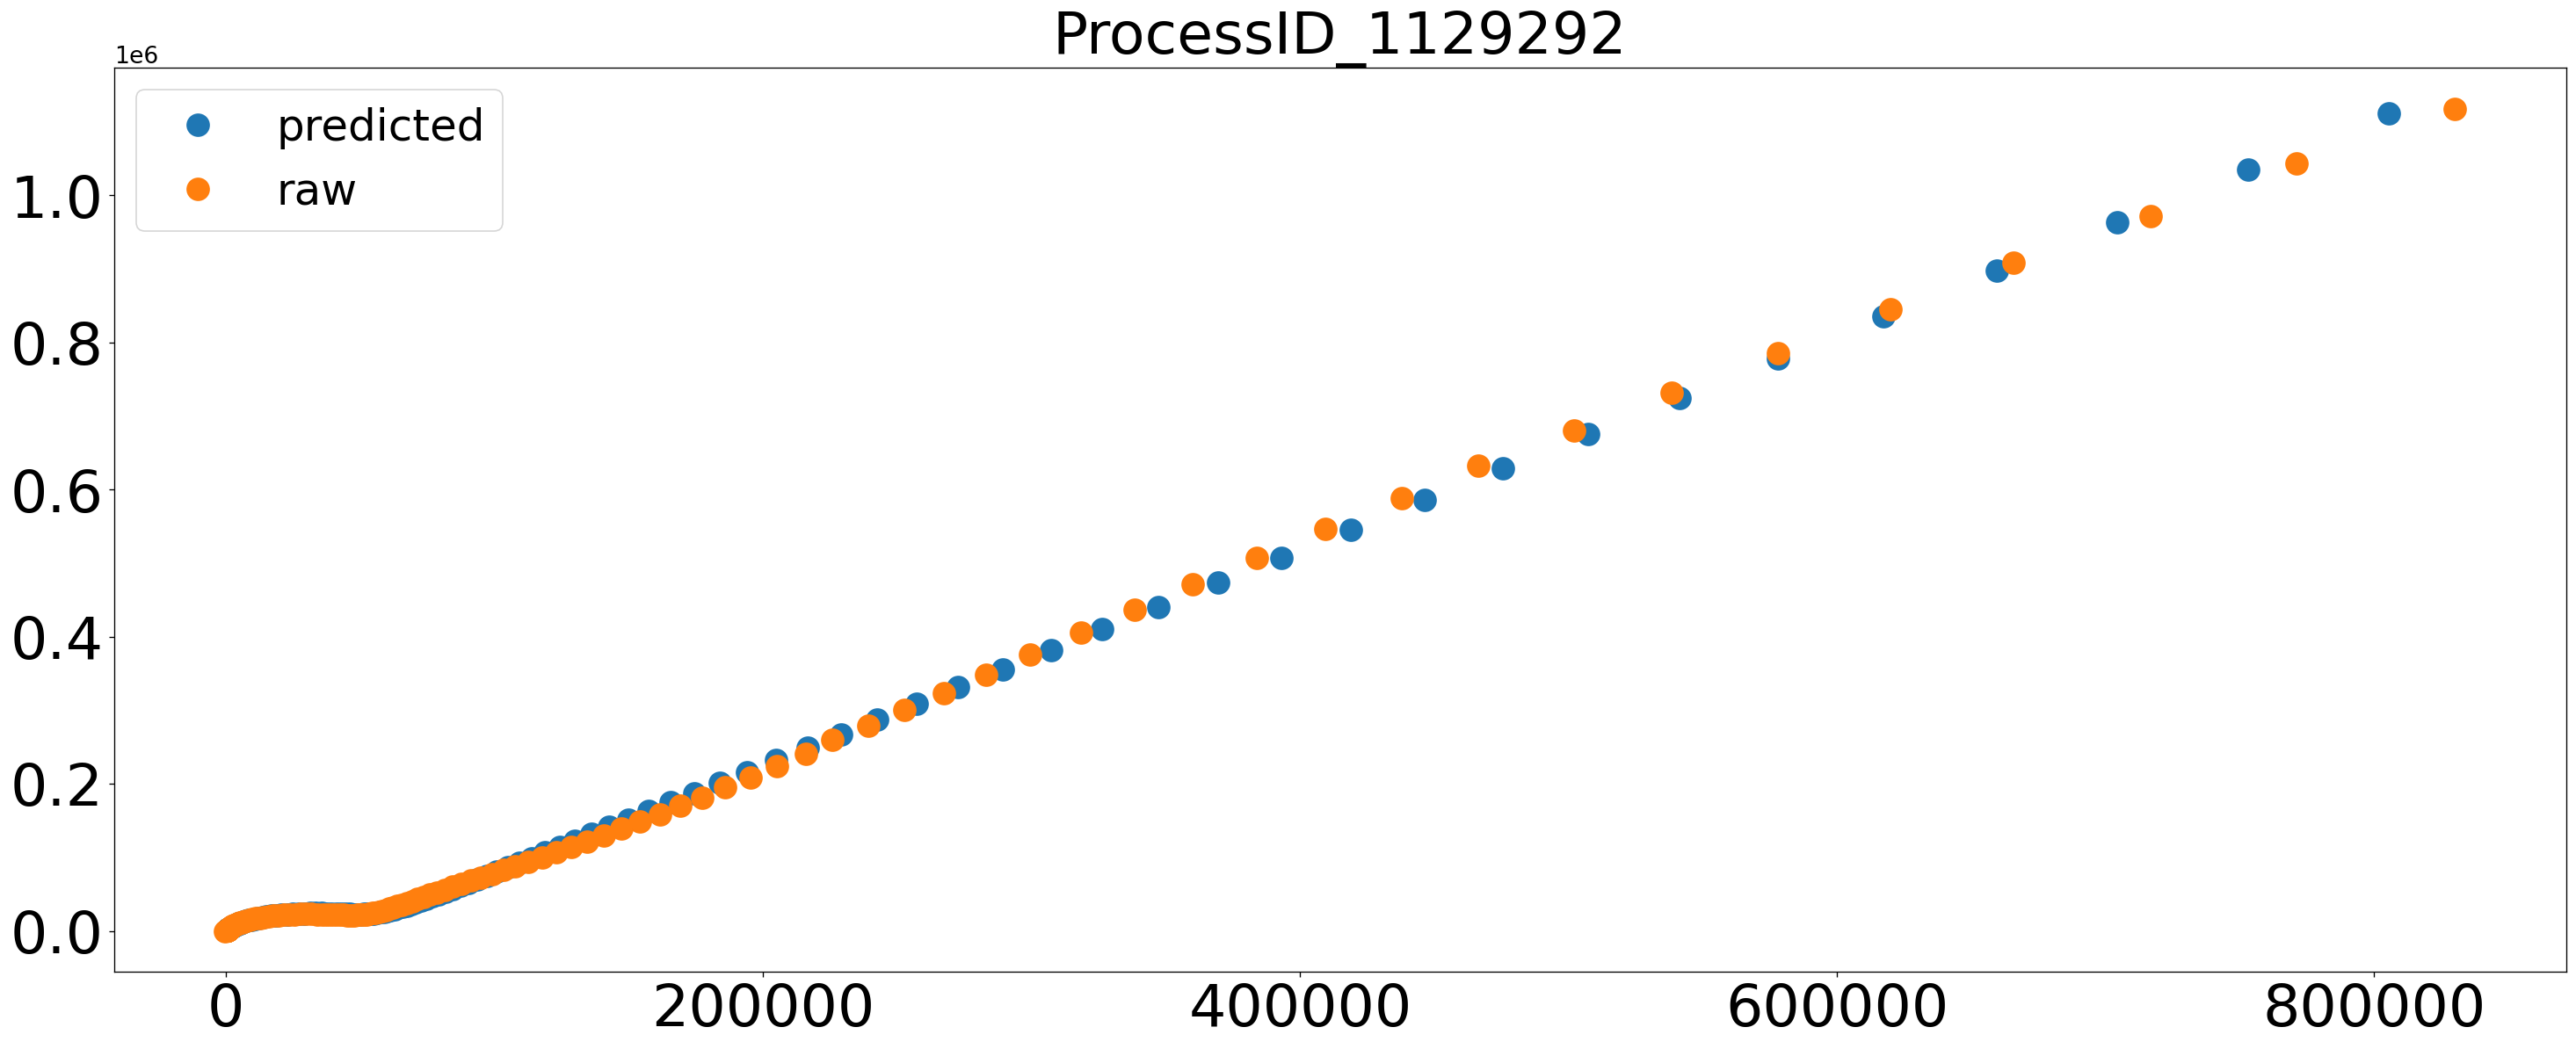

Progress:0.0472255018%
No handles with labels found to put in legend.


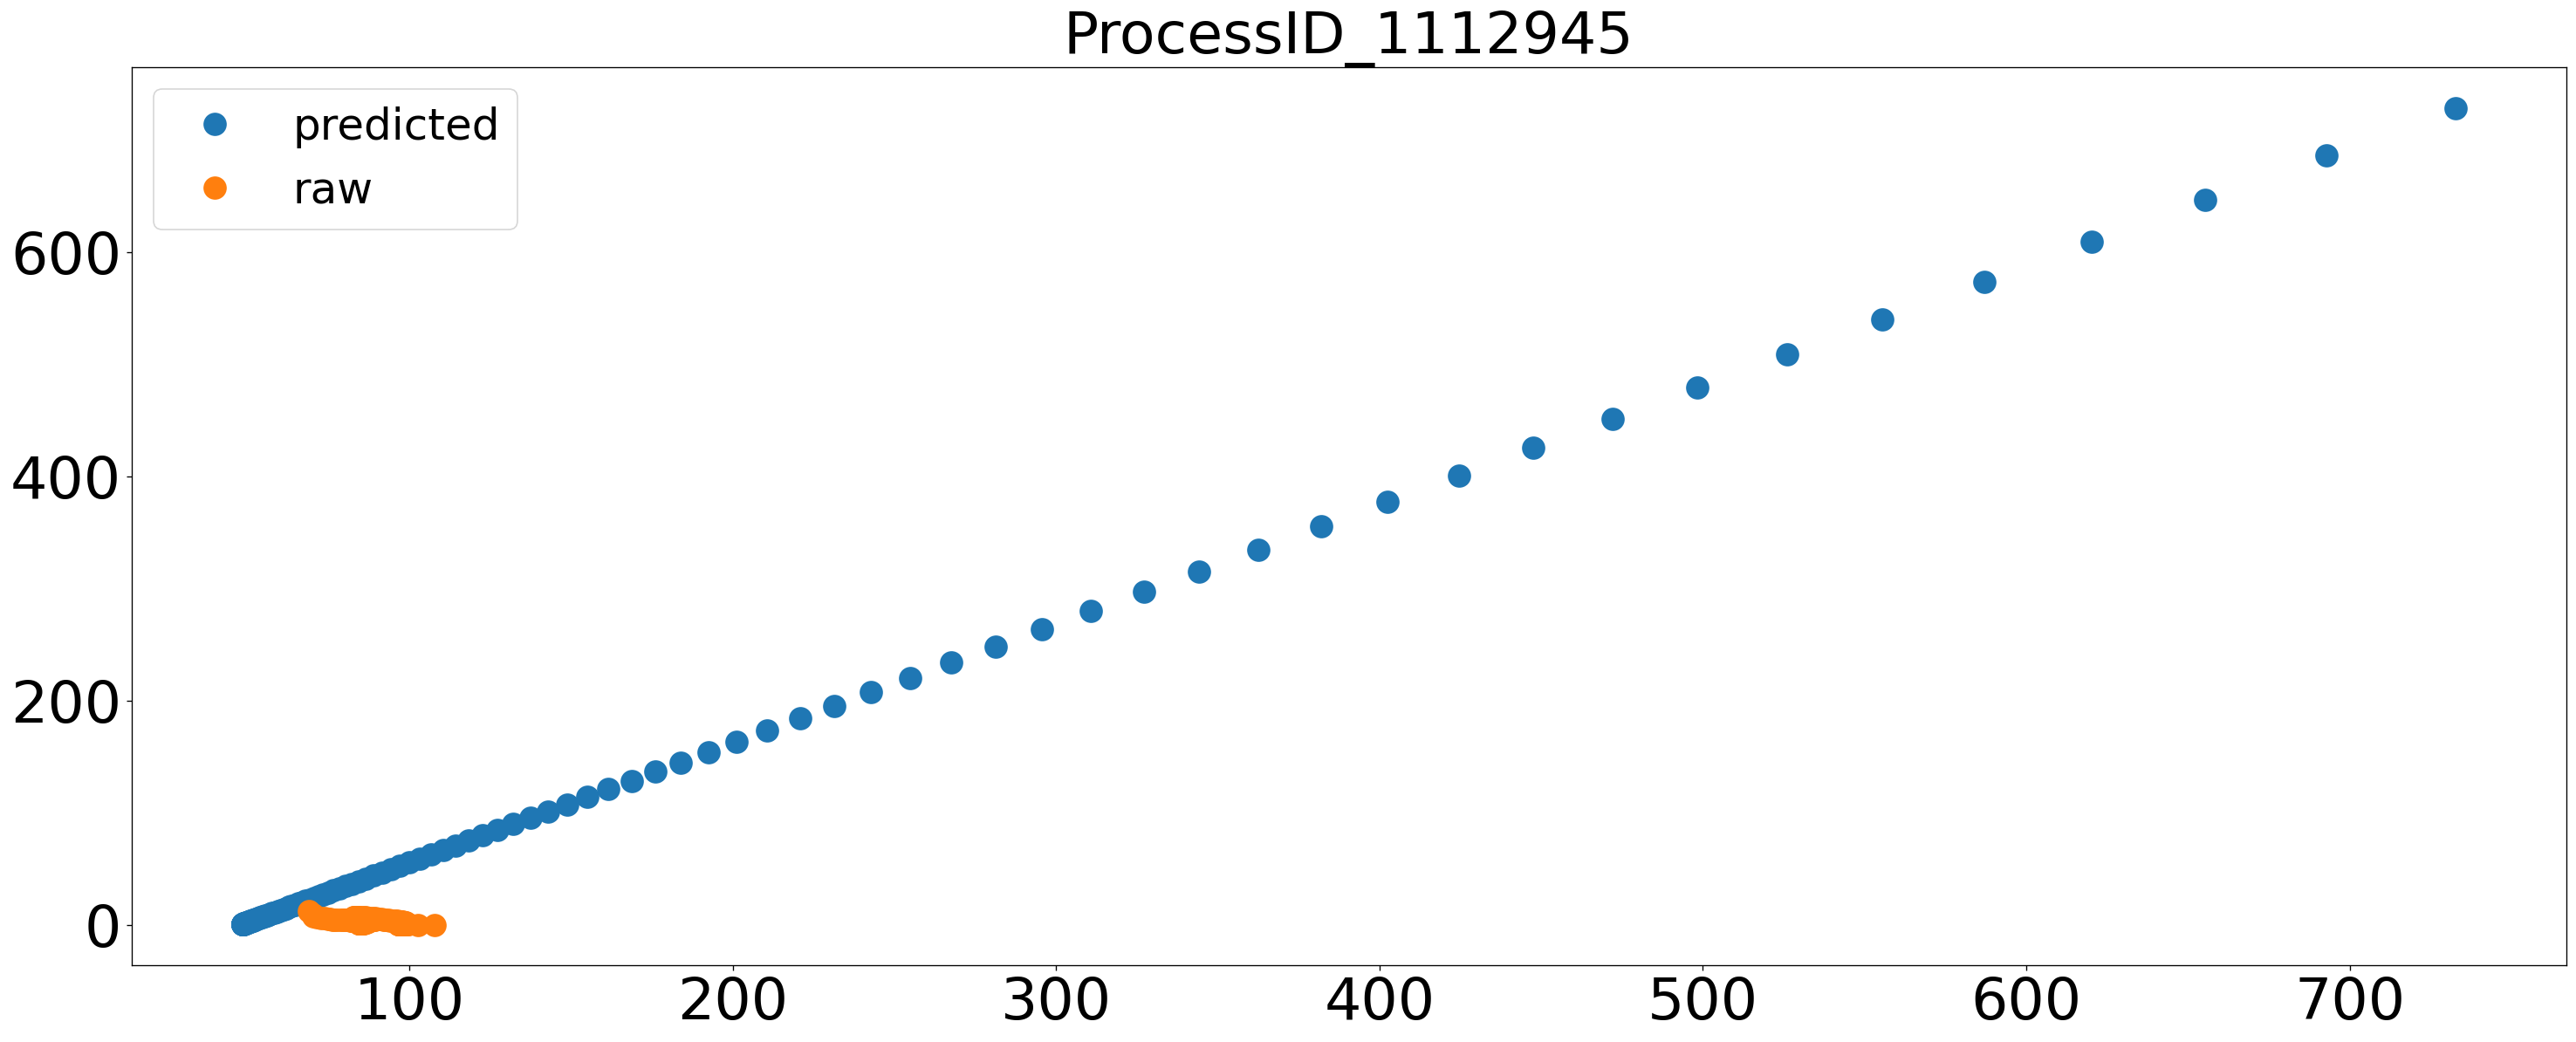

In [20]:
#SINGLE ITERATION OF THE baTch FITTING COMPUTATION
completed = []
errored = []
coeffs = {}
counter = 0
for x in list(ids)[:2]:
    single_id = str(x)
    try:
        if x not in completed:
            counter = counter + 1
            print("Progress:{:.10%}".format(counter/len(list(ids))))
            to_return = {}  
            cnxn = pyodbc.connect(pyodbc_cnntr)
            cursor = cnxn.cursor()    
            cursor.execute("SELECT Frequency_Hz, Minus_Z_Imaginary_Ohm, Z_Real_Ohm FROM ACImpedanceData_Raw WHERE Cycle = 1 and ProcessDataID = " + single_id)
            for row in cursor.fetchall():
                to_return.update({row.Frequency_Hz: [row.Z_Real_Ohm, row.Minus_Z_Imaginary_Ohm]})
            cnxn.close()
            #Formatting the database results into pd series for minimizing module function
            freq = pd.Series([np.float64(i) for i in list(to_return.keys())])
            re = pd.Series([np.float64(i[0]) for i in list(to_return.values())])
            im = pd.Series([np.float(i[1]) for i in list(to_return.values())])
            init_guesses = []
            param_list = []
            for i in range(20):
                #initial guesses still rely on the real values
                Rs_guess = min(re)
                R1_guess = max(re)//4
                n1_guess = random.uniform(0, 1)
                q1_guess = random.uniform(0, .001)
                R2_guess = 2*max(re)//4
                n2_guess = random.uniform(0, 1)
                q2_guess = random.uniform(0, .001)
                Q3_guess = random.uniform(0, .001)
                n3_guess = random.uniform(0, 1)
                params = Parameters()
                params.add('Rs', value=Rs_guess, min=Rs_guess*.001, max=Rs_guess*10)
                params.add('R1', value=R1_guess, min=R1_guess*.001, max=R1_guess*10)
                params.add('n1', value=n1_guess, min=0, max=1)
                params.add('Q1', value=q1_guess, min=0, max=.001)
                params.add('R2', value=R2_guess, min=R2_guess*.001, max=R2_guess*10)
                params.add('n2', value=n2_guess, min=.01, max=1)
                params.add('Q2', value=q2_guess, min=0, max=.001)
                params.add('Q', value=Q3_guess, min=0, max=.001)
                params.add('n', value=n3_guess, min=.01, max=1)
                param_list.append(params)
                circuit = 'R-RQ-RQ-Q'
                weight_func = 'modulus'
                nan_policy = 'raise'
                maxfev = 5000
                #MINIMIZE CANNOT TAKE IN LISTS
                #IT MUST BE PD SERIES
                #ALSO IT MUST BE CALLED SERIES.VALUES
                #NOT JUST SERIES
                fitted_data = minimize(leastsq_errorfunc, params, method='leastsq', args=(freq.values, re.values, im.values, circuit, weight_func), nan_policy=nan_policy, maxfev=maxfev)

                #print("CHI-SQ ERROR: ", fitted_data.chisqr)
                init_guesses.append(fitted_data.chisqr)
                #print("PARAMS")
                #pp.pprint(fitted_data.params)
            optimal_params = param_list[init_guesses.index(min(init_guesses))]
            fitted_dict = optimal_params.valuesdict()
            #fitted_dict['file'] = x
            completed.append(x)
            coeffs.update({x:fitted_dict})
            fitted_data=minimize(leastsq_errorfunc, optimal_params, method='leastsq', args=(freq.values, re.values, im.values, circuit, weight_func), nan_policy=nan_policy, maxfev=maxfev)

            #PLOTTING
            #Collecting the fitted data to prepare for plotting te points
            fitted_points = cir_RsRQRQQ(w=freq.values, Rs=fitted_data.params.get('Rs').value, Q=fitted_data.params.get('Q').value, n=fitted_data.params.get('n').value, R1=fitted_data.params.get('R1').value, Q1=fitted_data.params.get('Q1').value, n1=fitted_data.params.get('n1').value, fs1='None', R2=fitted_data.params.get('R2').value, Q2=fitted_data.params.get('Q2').value, n2=fitted_data.params.get('n2').value, fs2='None')
            fig = plt.figure(dpi=120, figsize = [30, 25], facecolor='w', edgecolor='w')
            #fig.subplots_adjust(left=0.1, right=0.95, hspace=0.5, bottom=0.1, top=0.95)
            ax = fig.add_subplot(211)
            ax.tick_params(axis='both', which='major', labelsize=40)
            ax.tick_params(axis='both', which='minor', labelsize=40)
            ### Figure specifics
            ax.set_title("ProcessID_"+single_id, fontsize = 40)
            ax.legend(loc='best', fontsize=30, frameon=False)
            #Color initialization
            colors = sns.color_palette("colorblind", n_colors=1)
            colors_real = sns.color_palette("Blues", n_colors=2)
            colors_imag = sns.color_palette("Oranges", n_colors=2)
            ax.plot(fitted_points.real, -fitted_points.imag, '.', label = 'predicted', markersize = 30)
            ax.plot(re, im, '.', label = 'raw', markersize = 30)
            ax.legend(fontsize = 30)
            plt.show()
        else:
            print("This file, ",x," has already been fitted")
    except:
        print("ProcessID_" + single_id + " could not be processed")
        errored.append(x)

In [22]:
coeffs

[OrderedDict([('Rs', -233.46834),
              ('R1', 207479.0),
              ('n1', 0.6965233892677999),
              ('Q1', 0.0004599753186479064),
              ('R2', 414958.0),
              ('n2', 0.9694898807193095),
              ('Q2', 0.0003511497359043607),
              ('Q', 0.00018739856771429143),
              ('n', 0.5058261784651503),
              ('file', 1129292)]),
 OrderedDict([('Rs', 68.889595),
              ('R1', 26.0),
              ('n1', 0.01794297191144123),
              ('Q1', 0.0007623510401178319),
              ('R2', 53.0),
              ('n2', 0.6009234028660988),
              ('Q2', 0.0002753850232773869),
              ('Q', 0.00010605274893234929),
              ('n', 0.5302464603219075),
              ('file', 1112945)])]

In [31]:
exp_dict = {}
for i in coeffs:
    exp_dict.update({i['file']:i})
exp_dict

{1129292: OrderedDict([('Rs', -233.46834),
              ('R1', 207479.0),
              ('n1', 0.6965233892677999),
              ('Q1', 0.0004599753186479064),
              ('R2', 414958.0),
              ('n2', 0.9694898807193095),
              ('Q2', 0.0003511497359043607),
              ('Q', 0.00018739856771429143),
              ('n', 0.5058261784651503),
              ('file', 1129292)]),
 1112945: OrderedDict([('Rs', 68.889595),
              ('R1', 26.0),
              ('n1', 0.01794297191144123),
              ('Q1', 0.0007623510401178319),
              ('R2', 53.0),
              ('n2', 0.6009234028660988),
              ('Q2', 0.0002753850232773869),
              ('Q', 0.00010605274893234929),
              ('n', 0.5302464603219075),
              ('file', 1112945)])}